### Описание проекта

Требуется создать модель прогнозирования цены рыночного продукта. Тестовым периодом считаются последние 365 дней в данных. <br>
Модель должна предсказывать значение цены продукта ежедневно в конце дня на день+7. <br>
Ошибка модели вычисляется как среднее по дневным ошибкам на всем тестовом периоде (ежедневно). <br>
#### Дневная ошибка = 100%*abs(forecast – actual)/actual,<br> 
где forecast – прогноз модели на день+7, actual – реальная цена по инструменту на день+7.<br>
Также необходимо сравнить точность модели с простой наивной моделью, когда значение цены на день+7 предсказывается  равным значению цены за последний день (день+0).<br> 

## План работы <a id = "plan"> </a>

[1. Подготовка данных](#1.)<br>
[2. Обучение моделей и поиск лучших гиперпараметров](#2.)<br>
[3. Финальное тестирование и анализ моделей](#3.)<br>

# 1. Подготовка и анализ данных <a id = "1."> </a>

[Вернуться к плану работы](#plan)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore') 
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
%matplotlib inline

price = pd.read_csv(r'E:\Документы прочие\IT\Тесовые задания\Северсталь\data.csv', 
                   parse_dates=[0], index_col=[0])

def data_info(data):
    '''Функция выводит информацию о датасете, первые 10 строк датасета и проверяет,
    что датасет расположен в хронологическом порядке.
    
    Args:
        data(DataFrame): Выбранный датасет.   
    '''
    data.info()
    display(data.head(10))
    if data.index.is_monotonic == True:
        print('Данные расположены в хронологическом порядке.')
    else:
        print('Данные расположены не в хронологическом порядке.')
    
def hist(data, c, t, b):
    '''Функция строит гистрограмму.
    
    Args:
        data(DataFrame): Выбранный датасет.
        с(str): Название колонки датасета.
        t(str): Название гистограммы.
        b(int): Количество корзин.
    '''
    plt.figure(figsize=(15, 10))
    plt.title(t, fontsize=15)
    sns.distplot(data[c], bins=b, kde=True)

def box_plt(data, c, t):
    '''Функция строит диаграмму ящик с усами.
    
    Args:
        data(DataFrame): Выбранный датасет.
        с(str): Название колонки датасета.
        t(str): Название диаграммы.
    '''
    plt.figure(figsize=(15,10))
    sns.boxplot(data = data[c])
    plt.title(t, fontsize=15)
    plt.grid(True)
    plt.show()
    
def min_max(data, c):
    ''' Функция выводит минимальное и максимальное значение.
    
    Args:
        data(DataFrame): Выбранный датасет.
        с(str): Название колонки датасета.
    '''
    print('Min:', data[c].min())
    print('Max:', data[c].max())

def decompose_plots(data):
    '''Функция раскладывает временной ряд на три составляющие: тренд, сезонность и остаток,
    и строит по ним линейные графики.
    
    Args:
        data(DataFrame): Выбранный датасет.
    '''
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(15, 10))
    plt.subplot(311)
    # Чтобы график корректно отобразился, указываем его
    # оси ax, равными plt.gca() (англ. get current axis,
    # получить текущие оси)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

Мы будем использовать датасет price, который содержит исторические данные о дневных ценах продукта.

In [2]:
data_info(price)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1400 entries, 2016-01-01 to 2019-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Value   1400 non-null   int64
dtypes: int64(1)
memory usage: 21.9 KB


,Value
Time,
2016-01-01,21448
2016-01-02,21448
2016-01-03,21448
2016-01-04,21448
2016-01-05,21448
2016-01-06,21448
2016-01-07,21448
2016-01-08,21448
2016-01-09,21448


Данные расположены в хронологическом порядке.


Датасет price размером в 1400 строк содержит 1 колоноку с ценой продукта, проиндексированную по времени с интервалом в 1 день. Общий временной интервал с 01.01.2016 по 31.10.2019. Данные не содержат пропусков и расположены в хронологическом порядке. Проанализируем изменение цен на протяжении всего периода.

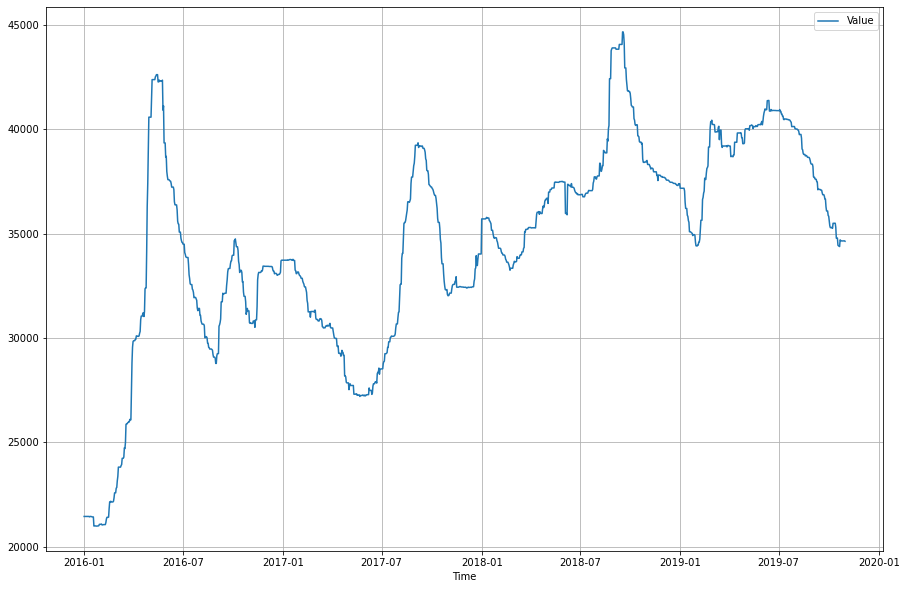

In [3]:
plt.figure(figsize=(15,10))
sns.lineplot(data = price)
plt.grid(True)
plt.show()

Цены изменялись на протяжении всего рассматриваемого периода. Наибольшее изменение можно наблюдать в период с 2016.01 до 2016.06. Проанализируем распределение цен.

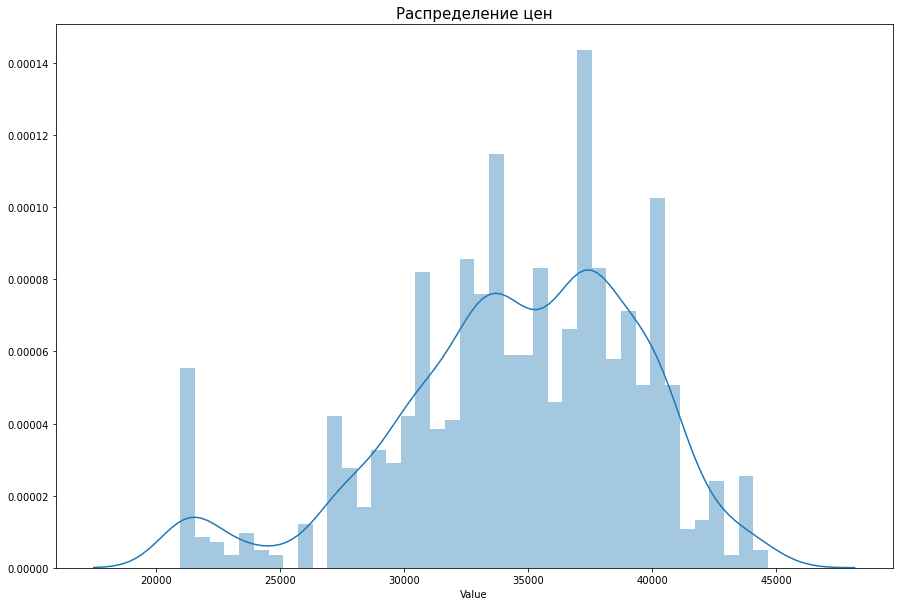

In [4]:
hist(price, 'Value', 'Распределение цен', 40)

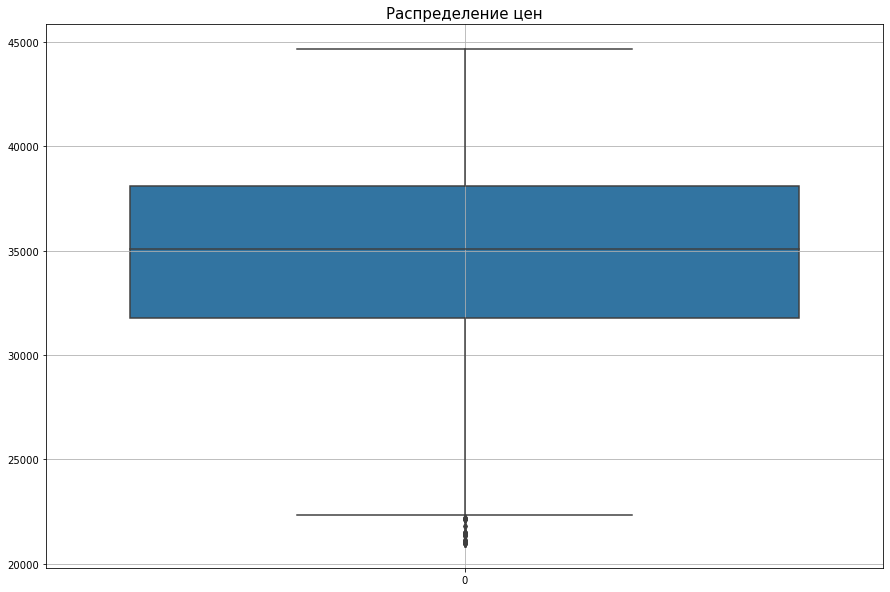

In [5]:
box_plt(price, 'Value', 'Распределение цен')

In [6]:
min_max(price, 'Value')

Min: 20986
Max: 44667


Распределение близко к нормальному виду и смещено вправо. У рапределения прослеживаются 3 вершины. Вероятно мы имеем дело с 3 подвидами продукта.  В данных содержаться выбросы - дни в которые цена продукта была очень маленькой. Разложим временной ряд на три составляющие: тренд, сезонность и остаток(шум - компонента, которая не объясняется трендом и сезонностью).

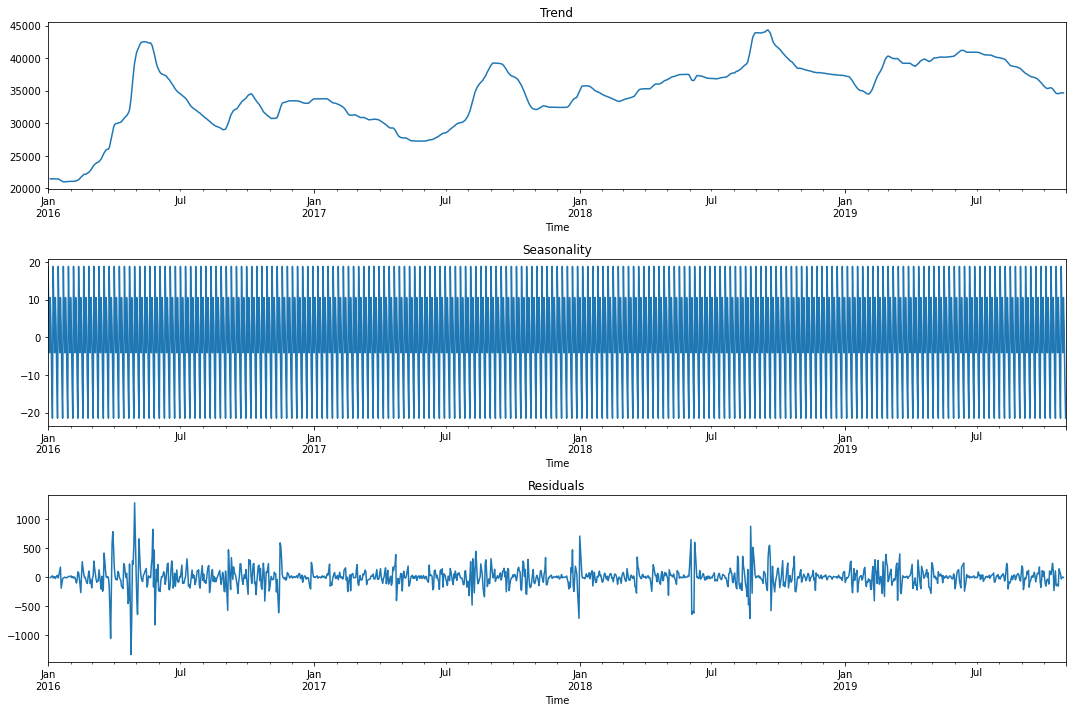

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_plots(price)

Из полученных графиков мы видим, что цена имеет восходящий тренд и увеличивается на протяжении 3-х лет. Также в данных присутствует сезонная составляющая и некоторое количество шумов, наиболее выраженных в мае-июне 2016 года.

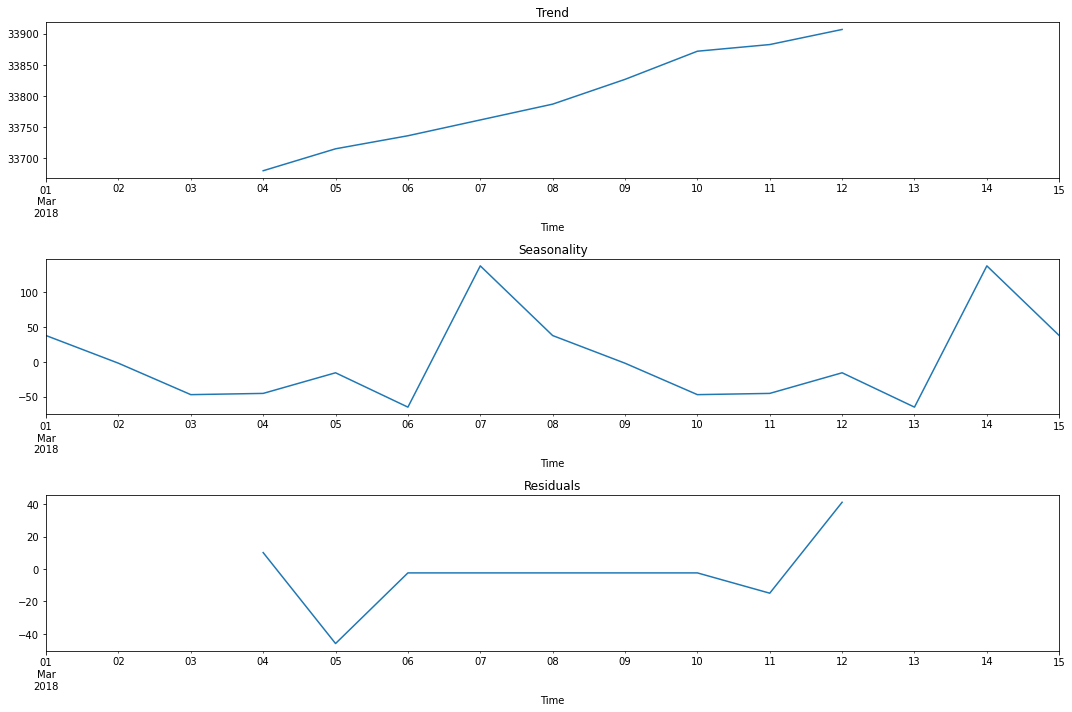

In [8]:
decompose_plots(price['2018-03-01':'2018-03-15'])

Проанализировав сезонную составляющую мы выяснили, что цикличность изменения цен составляет неделю. В среду цена продукта достигает своего максимума  и затем снижается до минимума ко вторнику.

### Вывод

Была изучена общая информация о полученных данных. В данных отсутствуют пропуски. Распределение имеет вид близкий нормальному со смещением вправо, а также прослеживаются 3 вершины. Также в данных содержаться выбросы (шумы), сезонная компонента и тренд.

# 2. Обучение моделей и поиск лучших гиперпараметров <a id = "2."> </a>

[Вернуться к плану работы](#plan)

Подготовим данные для обучения:
- выделим из данных дополнительные признаки
- разобьем датасет на обучающую и тестовую выборки (тестовая выборка последние 365 дней)
- выделим у обучающей и тестовой выборки признаки и целевой признак

In [9]:
def prepareData(data, lag_start, lag_end, rolling_mean_size):
    '''Функция добавляет признаки в датасет, очищает его от пропусков, 
    разбивает выборку на обучающую и тестовую и выделяет у них признаки и целевой признак.
    
    Args:
        data(DataFrame): Выбранный датасет.
        lag_start(int): Начало лага.
        lag_end(int): Конец лага.
        rolling_mean_size(int): Размер окна для скользящего среднего.
    '''
    data = pd.DataFrame(data.copy())
    data.columns = ['y']

    data['rolling_mean'] = data['y'].shift(lag_start).rolling(rolling_mean_size).mean()    
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['year'] = data.index.year
    
    # очищаем пропуски
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на обучающую и тестовую выборки
    train = data[:-365]
    test = data[-365:]
    
    # выделим у обучающей и тестовой выборки признаки и целевой признак
    X_train = train.drop(['y'], axis=1)
    y_train = train['y']
    X_test = test.drop(['y'], axis=1)
    y_test = test['y']

    return X_train, X_test, y_train, y_test

Согласно условию "Модель должна предсказывать значение цены продукта ежедневно в конце дня на день+7". Поэтому размер лага будем брать начиная с 7 таким образом модель будет способна строить предсказания на 7 дней вперед, имея фактические наблюдения за предыдущие 7 дней.

In [10]:
X_train, X_test, y_train, y_test = prepareData(price, 7, 14, 7)

В данных присутствуют колличественные признаки с разными разбросами значений. Для того, чтобы алгоритм не решил, что признаки с большими значениями и разбросом важнее, маcштабируем количественные признаки.

In [11]:
from sklearn.preprocessing import MinMaxScaler

numeric = ['rolling_mean'] + X_train.columns[X_train.columns.str.contains('lag')].to_list()
scaler = MinMaxScaler()
scaler.fit(X_train[numeric])

# масштабируем обучающую выборку
X_train[numeric] = scaler.transform(X_train[numeric])

# масштабируем тестовую выборку
X_test[numeric] = scaler.transform(X_test[numeric])

Для решения задачи введём новую метрику качества — MAPE (англ. Mean Absolute Percentage Error, «среднее абсолютное процентное отклонение»).

In [12]:
from sklearn.metrics import make_scorer

def MAPE(y_true, y_pred): 
    '''Функция проводит расчет метрики MAPE.
    
    Args:
        y_true(Series): Ответы.
        y_pred(Series): Предсказания.
    ''' 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# создаем метрику, которую мы будем максимизировать, подбирая подходящие параметры модели
MAPE_scorer = make_scorer(MAPE, greater_is_better = False)

Вычислим наилучшую метрику MAPE на кросс-валидации и подберем для моделей наилучшие гиперпараметры. Кросс-валидацию мы будем проводить с помощью TimeSeriesSplit, которая учитывает расположение фолдов и не меняет их местами, как при обычной кросс-валидации.

In [13]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

### LinearRegression

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

def lr_gridsearchcv(features, target):
    '''Функция рассчитывает и выдает словарь с лучшими гиперпараметрами 
    и лучшее значение метрики для модели линейной регрессии.
    
    Args:
        features(DataFrame): Признаки.
        target(DataFrame, Series): Целевой(ые) признак(и).
    '''
    model = LinearRegression()
    param_grid = {
        'fit_intercept' : [True, False],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= tscv,  scoring = MAPE_scorer)
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее MAPE: {:.4f}%'.format(-CV.best_score_))
    return CV.best_params_     

In [15]:
%%time
best_params_lr = lr_gridsearchcv(X_train, y_train)

Лучшие гиперпараметры:  {'fit_intercept': True}
Лучшее MAPE: 1.6447%
Wall time: 76 ms


### RandomForestRegressor

In [16]:
from sklearn.ensemble import RandomForestRegressor

def rfr_gridsearchcv(features, target):
    '''Функция рассчитывает и выдает словарь с лучшими гиперпараметрами 
    и лучшее значение метрики для модели случайного леса регрессии.
    
    Args:
        features(DataFrame): Признаки.
        target(DataFrame, Series): Целевой(ые) признак(и).
    '''
    model = RandomForestRegressor()
    param_grid = {
        'random_state': [42],
        'n_estimators': range(1,201,40),
        'max_features': ['auto', 'sqrt', 'log2', None],
        'max_depth' : [range(1,10,1), None]
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= tscv,  scoring = MAPE_scorer)
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее MAPE: {:.4f}%'.format(-CV.best_score_))
    return CV.best_params_ 

In [17]:
%%time
best_params_rfr = rfr_gridsearchcv(X_train, y_train)

Лучшие гиперпараметры:  {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 121, 'random_state': 42}
Лучшее MAPE: 3.6816%
Wall time: 16.9 s


### LGBMRegressor

In [18]:
import lightgbm as lgb

def lgbm_gridsearchcv(features, target):
    '''Функция рассчитывает и выдает словарь с лучшими гиперпараметрами 
    и лучшее значение метрики для модели LGBMRegressor.
    
    Args:
        features(DataFrame, Series): Признаки.
        target(DataFrame, Series): Целевой(ые) признак(и).
    '''
    model = lgb.LGBMRegressor()
    param_grid = {
            'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
            'objective': ['regression'],
            'n_estimators': [800],
            'learning_rate': [0.001, 0.03, 0.1, 0.15],
            'max_depth': np.arange(4, 7),
            'random_state': [42],
    }
    CV = GridSearchCV(estimator = model, param_grid = param_grid, cv= tscv, scoring = MAPE_scorer)
    CV.fit(features, target)
    print('Лучшие гиперпараметры: ', CV.best_params_)
    print('Лучшее MAPE: {:.4f}%'.format(-CV.best_score_))
    return CV.best_params_ 

In [19]:
%%time
best_param_lgbm = lgbm_gridsearchcv(X_train, y_train)

Лучшие гиперпараметры:  {'boosting_type': 'gbdt', 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 800, 'objective': 'regression', 'random_state': 42}
Лучшее MAPE: 4.6443%
Wall time: 36.2 s


### Вывод

Мы провели кросс-валидацию обучающей выборки и подобрали для моделей лучшие гиперпараметры. Лучшее значение MAPE на обучающей выборке показала модель LinearRegression.

# 3. Финальное тестирование и анализ моделей <a id = "3."> </a>

[Вернуться к плану работы](#plan)

In [20]:
def ml(model, features_train, target_train, features_test, target_test):
    '''Функция обучает заданную модель по обучающей выборке 
    и расчитывает метрику RMSE по тестовой выборке.
    
    Args:
        model(Estimator): Модель.
        features_train(DataFrame, Series): Признак(и) обучающей выборки.
        target_train(DataFrame, Series): Целевой(ые) признак(и) обучающей выборки.
        features_test(DataFrame, Series): Признак(и) тестовой выборки.
        target_test(DataFrame, Series): Целевой(ые) признак(и) тестовой выборки.
    '''
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    # считаем MAPE модели
    mape = MAPE(target_test, predictions)
    print('MAPE модели: ', round(mape, 4), '%')
    # считаем MAPE naive
    # размер сдвига из условия задачи (naive предсказывает день+7 как день+0)
    s = 7 
    pred_previous = target_test.shift(s)
    # заполним пропуски значениями из обучающей выборки
    for i in range(0, s+1):
        pred_previous.iloc[i] = target_train.iloc[-s]
        s += 1
    mape_naive = MAPE(target_test, pred_previous)
    print('MAPE naive: ', round(mape_naive, 4), '%')
    #строим график предсказаний, наивных предсказаний и ответов
    time_series_true_pred_plot(predictions, target_test, pred_previous)
    
def time_series_true_pred_plot(predictions, y_test, pred_previous):
    '''Функция строит график предсказаний, наивных предсказаний и ответов.
    
    Args:
        predictions(DataFrame, Series): Предсказания.
        y_test(DataFrame, Series): Ответы тестовой выборки.
        pred_previous(DataFrame, Series): Ответы тестовой выборки cо сдвигом.
    '''
    plt.figure(figsize=(15, 7))
    # строим график предсказаний
    plt.plot(predictions, color='red',  label = 'model')
    # строим график ответов
    plt.plot(y_test.values, color='blue', label = 'actual')
    # строим график наивных предсказаний
    plt.plot(pred_previous.values, color='green', label = 'naive')
    plt.legend(loc = 'best')
    plt.grid(True)

Проанализируем обученные модели на тестовой выборке.

### LinearRegression

MAPE модели:  1.1201 %
MAPE naive:  1.1538 %


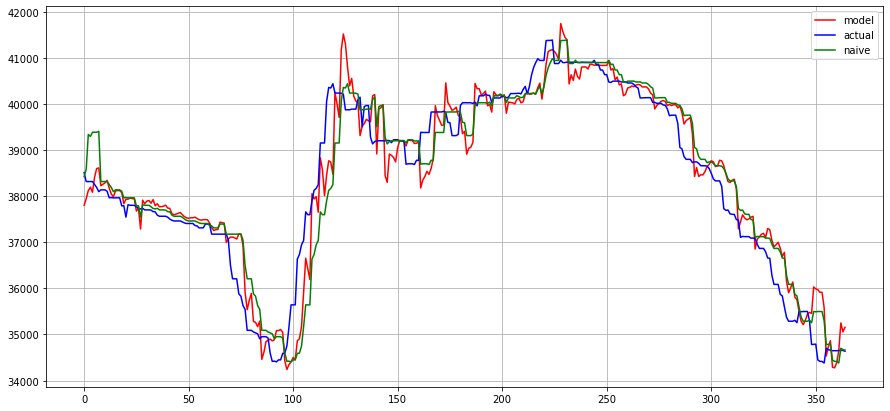

In [21]:
model_lr = LinearRegression(**best_params_lr)
ml(model_lr, X_train, y_train, X_test, y_test)

### RandomForestRegressor

MAPE модели:  1.1201 %
MAPE naive:  1.1538 %


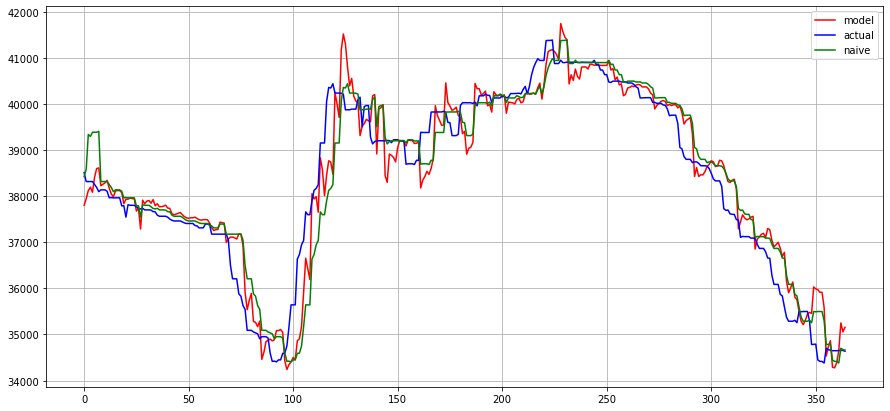

In [22]:
model_rfr = RandomForestRegressor(**best_params_rfr)
ml(model_lr, X_train, y_train, X_test, y_test)

### LGBMRegressor

MAPE модели:  2.4131 %
MAPE naive:  1.1538 %


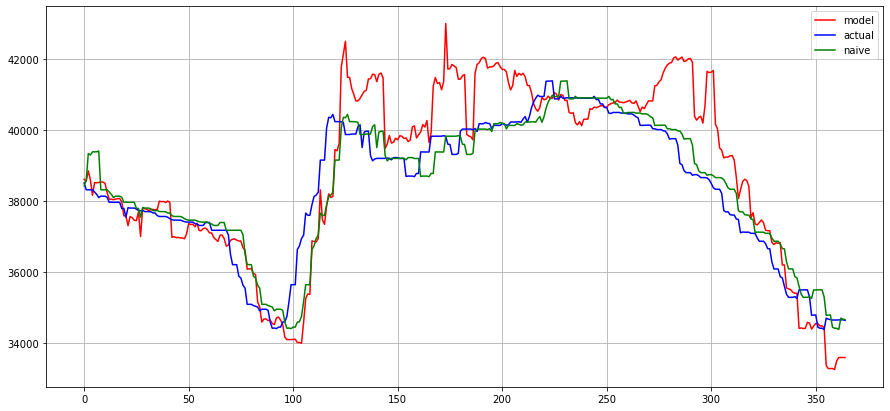

In [23]:
model_lgbm = lgb.LGBMRegressor(**best_param_lgbm)
ml(model_lgbm, X_train, y_train, X_test, y_test)

### Вывод

Наиболее точно предсказала цены модель LinearRegression и RandomForestRegressor с MAPE 1.1201%. Также эти модели предсказывает лучше, чем naive модель.

## ИТОГ

Были проанализированы данные. Для целей предсказания были обучены 3 варианта моделей, проведена кросс-валидация и получены лучшие гиперпараметры. В результате фианального тестирования наилучшую метрику MAPE 1.1201% показали модели LinearRegression и RandomForestRegressor, которые к тому же предсказывают лучше, чем наивная модель.